In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import time
import deepdish as dd
from sequence_annotation.genome_handler.seq_container import AnnSeqContainer
from sequence_annotation.data_handler.fasta import read_fasta
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sequence_annotation.genome_handler.utils import loader
from sequence_annotation.pytorch.AS_space_finder import ASModelSpaceFinder
from sequence_annotation.pytorch.AS_model_facade import ASModelFacade
from sequence_annotation.pytorch.customize_layer import GatedIndRnnCell
simplify_map={'exon':['exon'],'intron':['intron','mix'],'other':['other']}

Using TensorFlow backend.


In [26]:
fasta = read_fasta('../io/long_read/termite/isoseq.ccs.polished.hq.fasta_align_to_termite_g1_2019_03_01/result/result_dist_to_five_500_dist_to_three_500_merged.fasta')
h5=dd.io.load('../io/long_read/termite/isoseq.ccs.polished.hq.fasta_align_to_termite_g1_2019_03_01/result/result_dist_to_five_500_dist_to_three_500_merged.h5')
ann_seqs = AnnSeqContainer().from_dict(h5)

In [27]:
print(len(ann_seqs))

2105


In [28]:
selected_fasta,selected_seqs,o_s,o_a = loader(fasta,ann_seqs,
                                              simplify_map=simplify_map,
                                              min_len=2000,max_len=4000,outlier_coef=1.2)

In [29]:
len(o_s)

4212

In [30]:
print(len(selected_seqs))

273


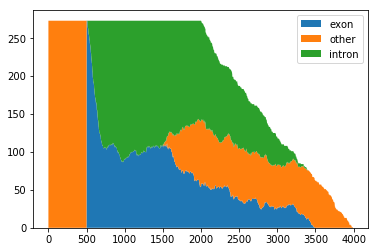

In [31]:
from sequence_annotation.visual.visual import visual_ann_genome
visual_ann_genome(selected_seqs)

In [32]:
space={
    'cnn_output':32,
    'cnn_num':3,
    'rnn_output':32,
    'rnn_num':2,
    'cnn_kernel_size':hp.quniform('cnn_kernel_size', 3, 128, 2),
    'PWM':hp.choice('PWM',[True,False]),
    'rnn_cell_class':GatedIndRnnCell
}

In [33]:
trials = Trials()
facade = ASModelFacade(selected_fasta,selected_seqs,'../io/record/termite_2019_03_15',ratio=[0.7,0.2,0.1])
facade.lr=1e-3
facade.batch_size=16
facade.epoch_num=100
facade.patient=4
facade.affect_length_max=500

192 {'exon': 154743.0, 'other': 192000.0, 'intron': 219525.0}
54 {'exon': 37581.0, 'other': 54000.0, 'intron': 61122.0}
27 {'exon': 19593.0, 'other': 27000.0, 'intron': 32936.0}


In [34]:
trainer = ASModelSpaceFinder(facade,'../io/record/termite_2019_03_15')

In [ ]:
best = fmin(trainer.objective, space, algo=tpe.suggest, max_evals=16,trials=trials)

1 {'rnn_num': 2, 'PWM': False, 'cnn_kernel_size': 60.0, 'rnn_output': 32, 'cnn_num': 3, 'rnn_cell_class': <class 'sequence_annotation.pytorch.customize_layer.GatedIndRnnCell'>, 'cnn_output': 32}
Processing data...
Processing model..
Compiling model...
Processing worker...
Executing...
Start working(2019-03-15 10:57:21)
CNN time 0
RNN time 11


In [118]:
dd.io.save(trainer.root+'/records.h5',trainer.records)
dd.io.save(trainer.root+'/space_result.h5',trainer.space_result)

In [117]:
import pickle
with open("../io/record/termite_2019_03_15/trials.hyperopt", "wb") as f:
    pickle.dump(trials, f)

In [112]:
best

{'PWM': 1, 'cnn_kernel_size': 60.0}

In [76]:
new_x, new_y = 

In [91]:
pwm_x=[item['space']['cnn_kernel_sizes'][0] for item in trainer.space_result.values() if item['space']['PWM'] is True]
pwm_y=[item['val_macro_F1'] for item in trainer.space_result.values() if item['space']['PWM'] is True]
pwm_x,pwm_y = zip(*sorted(zip(pwm_x, pwm_y)))

In [92]:
x=[item['space']['cnn_kernel_sizes'][0] for item in trainer.space_result.values() if item['space']['PWM'] is False]
y=[item['val_macro_F1'] for item in trainer.space_result.values() if item['space']['PWM'] is False]
x,y = zip(*sorted(zip(x, y)))

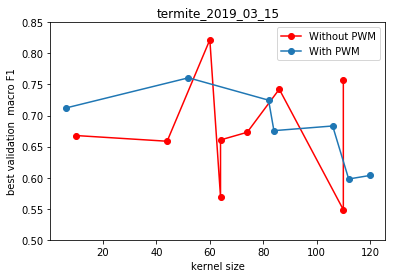

In [121]:
from matplotlib import pyplot
pyplot.xlabel('kernel size')
pyplot.ylabel('best validation  macro F1')
pyplot.plot(x,y,'-o',color='red',label='Without PWM')
pyplot.plot(pwm_x,pwm_y,'-o',label='With PWM')
pyplot.legend()
pyplot.ylim(0.5,0.85)
pyplot.title('termite_2019_03_15')
pyplot.savefig(trainer.root+"/termite_model_space_result_plot_2019_03_17.png")

In [171]:
data = {}
for id_ in trainer.space_result.keys():
    item = trainer.space_result[id_]
    data[id_] = {'cnn_kernel_sizes':item['space']['cnn_kernel_sizes'][0],
                 'PWM':item['space']['PWM'],
                 'val_macro_F1':round(item['val_macro_F1'],2)}
    for key,val in trainer.test_record[id_].items():
        data[id_][key] = round(val[0],2)

In [172]:
data

{1: {'PWM': False,
  'cnn_kernel_sizes': 60,
  'test_F1_exon': 0.56,
  'test_F1_intron': 0.8,
  'test_F1_other': 0.84,
  'test_accuracy': 0.76,
  'test_loss': 3346.21,
  'test_macro_F1': 0.76,
  'val_macro_F1': 0.82},
 2: {'PWM': True,
  'cnn_kernel_sizes': 6,
  'test_F1_exon': 0.52,
  'test_F1_intron': 0.66,
  'test_F1_other': 0.74,
  'test_accuracy': 0.64,
  'test_loss': 2412.22,
  'test_macro_F1': 0.66,
  'val_macro_F1': 0.71},
 3: {'PWM': True,
  'cnn_kernel_sizes': 82,
  'test_F1_exon': 0.3,
  'test_F1_intron': 0.72,
  'test_F1_other': 0.44,
  'test_accuracy': 0.55,
  'test_loss': 3431.65,
  'test_macro_F1': 0.55,
  'val_macro_F1': 0.72},
 4: {'PWM': True,
  'cnn_kernel_sizes': 84,
  'test_F1_exon': 0.37,
  'test_F1_intron': 0.72,
  'test_F1_other': 0.56,
  'test_accuracy': 0.61,
  'test_loss': 3358.83,
  'test_macro_F1': 0.6,
  'val_macro_F1': 0.68},
 5: {'PWM': False,
  'cnn_kernel_sizes': 110,
  'test_F1_exon': 0.34,
  'test_F1_intron': 0.15,
  'test_F1_other': 0.47,
  'test_ac

In [179]:
import pandas as pd
df = pd.DataFrame.from_dict(data).T

In [180]:
#df.index+=1
df

,PWM,cnn_kernel_sizes,test_F1_exon,test_F1_intron,test_F1_other,test_accuracy,test_loss,test_macro_F1,val_macro_F1
1,False,60,0.56,0.8,0.84,0.76,3346.21,0.76,0.82
2,True,6,0.52,0.66,0.74,0.64,2412.22,0.66,0.71
3,True,82,0.3,0.72,0.44,0.55,3431.65,0.55,0.72
4,True,84,0.37,0.72,0.56,0.61,3358.83,0.6,0.68
5,False,110,0.34,0.15,0.47,0.32,7437.87,0.36,0.55
6,False,64,0.41,0.59,0.8,0.6,4166.31,0.61,0.66
7,True,106,0.38,0.71,0.8,0.67,2426.75,0.65,0.68
8,False,86,0.49,0.74,0.78,0.7,3323.91,0.69,0.74
9,True,112,0.47,0,0.71,0.43,6779.77,0.45,0.6
10,False,64,0.46,0.72,0.72,0.66,2787.81,0.64,0.57
